## SIMLR with Leukemia and ALLAML Dataset


Loading Dataset 1...

Performing PCA for dimensionality reduction on Dataset 1...

Running SIMLR algorithm on Dataset 1 (c=2, k=15)...

Clustering completed for Dataset 1.
Cluster sizes: Counter({1: 50, 0: 22})

Evaluating clustering performance for Dataset 1:

--- Evaluation Metrics ---
Adjusted Rand Index (ARI):     -0.0248
Normalized Mutual Information: 0.0087
Silhouette Score:              0.0445
Purity Score:                  0.6528

Generating plots for Dataset 1...


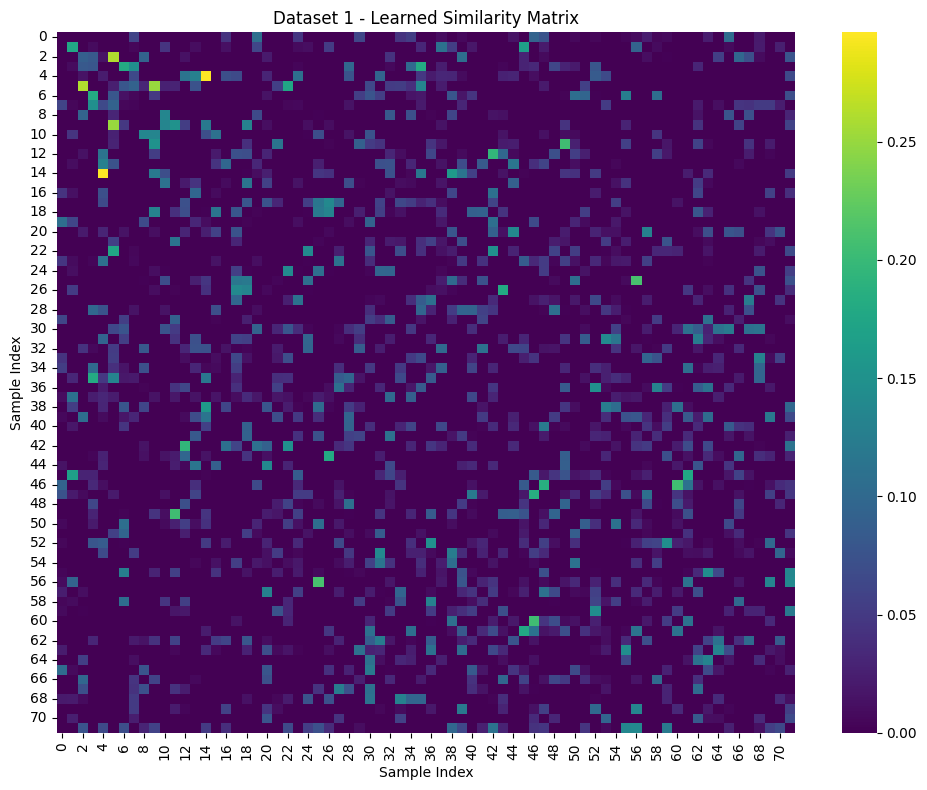

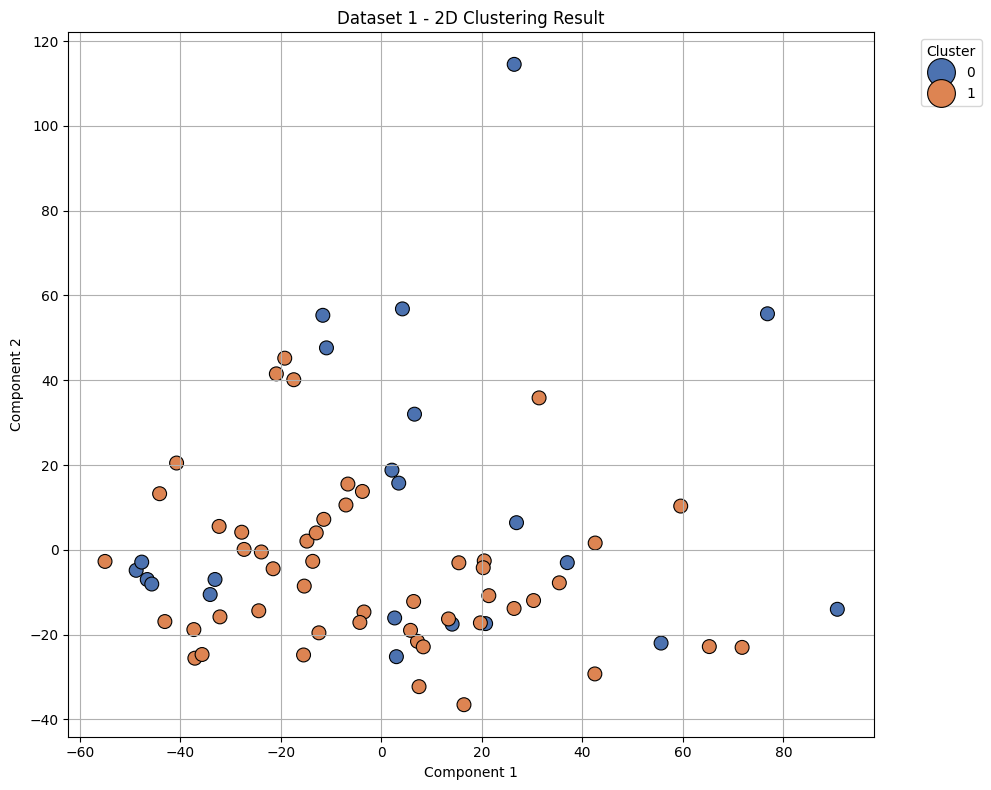


Cluster-wise Feature Variance:


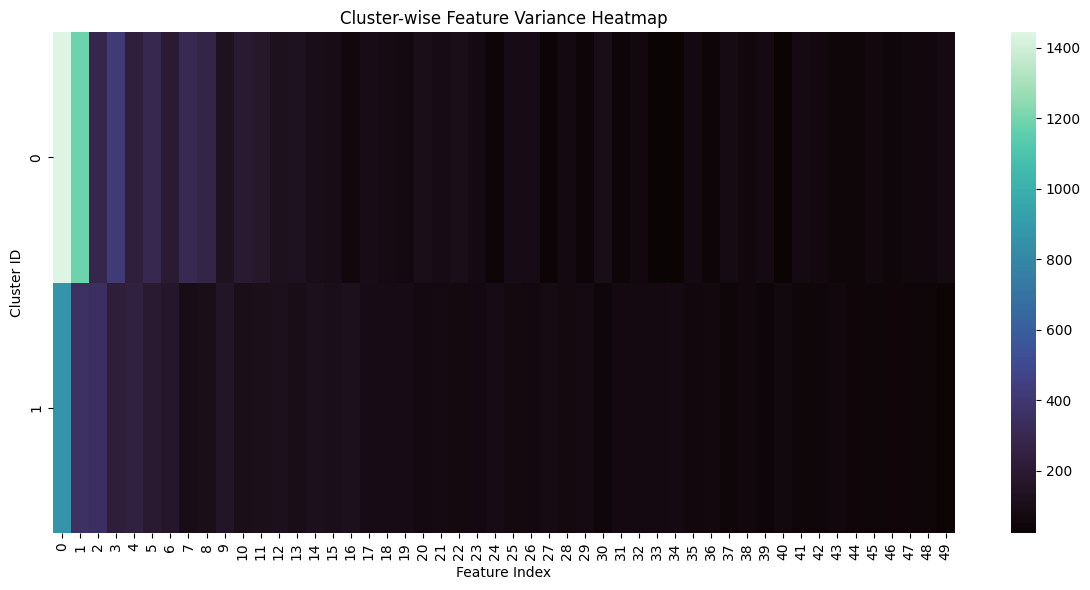


Finished plotting results for Dataset 1.

Loading Dataset 2...

Performing PCA for dimensionality reduction on Dataset 2...

Running SIMLR algorithm on Dataset 2 (c=2, k=15)...

Clustering completed for Dataset 2.
Cluster sizes: Counter({1: 36, 0: 36})

Evaluating clustering performance for Dataset 2:

--- Evaluation Metrics ---
Adjusted Rand Index (ARI):     -0.0122
Normalized Mutual Information: 0.0006
Silhouette Score:              0.0039
Purity Score:                  0.6528

Generating plots for Dataset 2...


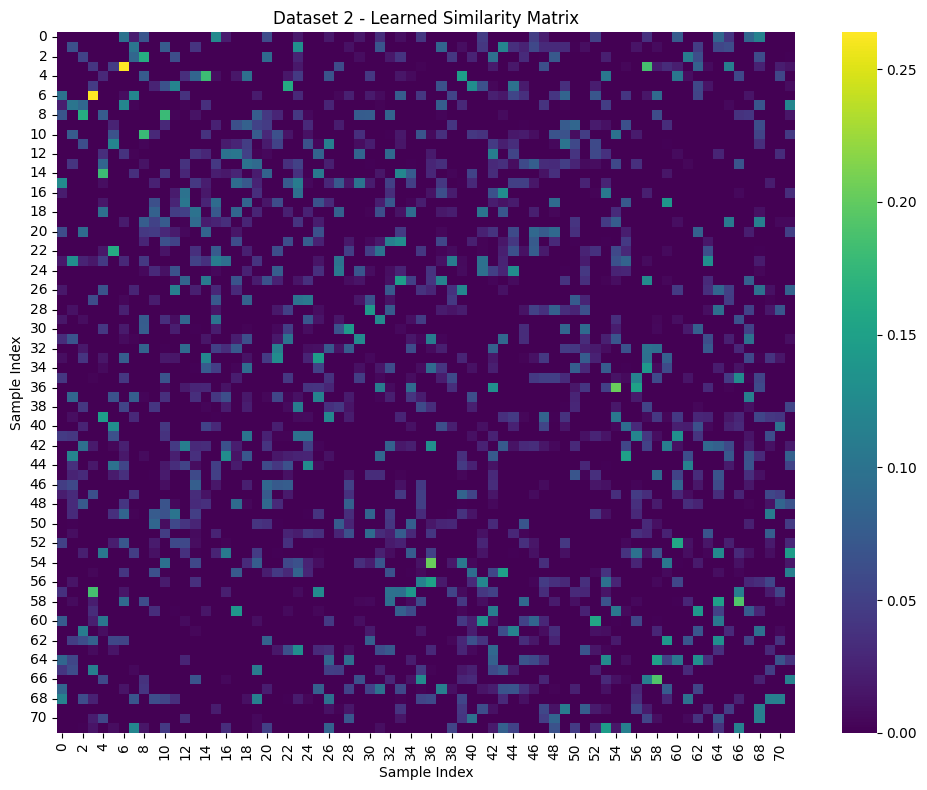

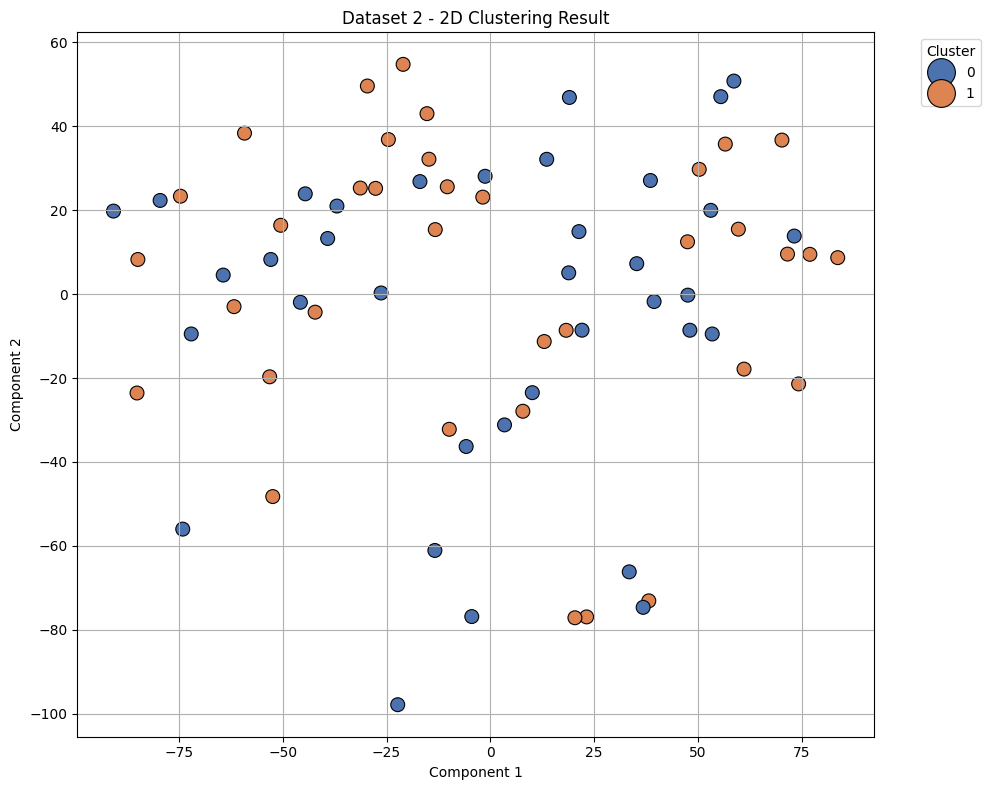


Cluster-wise Feature Variance:


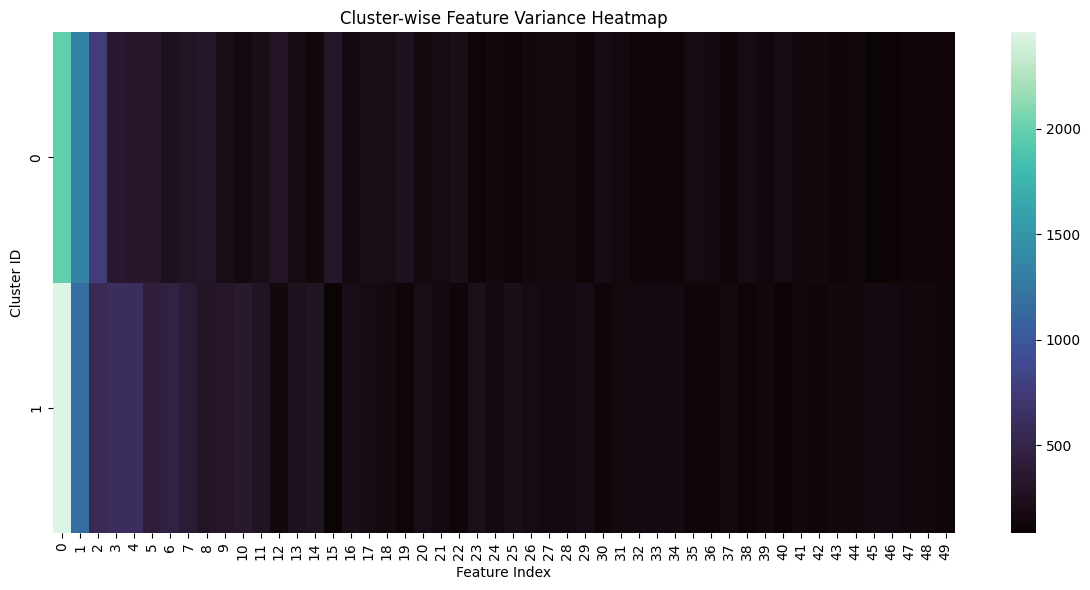


Finished plotting results for Dataset 2.


In [ ]:
import numpy as np
import time
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.metrics.cluster import contingency_matrix
from collections import Counter

# ------------------------ Load Dataset ------------------------

def load_leukemia_data(filepath):
    mat = sio.loadmat(filepath)
    X = mat.get('X', mat.get('data', None))
    if X is None:
        for key, val in mat.items():
            if isinstance(val, np.ndarray) and val.ndim == 2:
                X = val
                break
    Y = mat.get('Y', mat.get('labels', None))
    if Y is None:
        for key, val in mat.items():
            if isinstance(val, np.ndarray) and val.ndim == 1:
                Y = val
                break
    return np.array(X, dtype=np.float64), Y.flatten() if Y is not None else None

# ------------------------ Perform Manual PCA ------------------------

def pca_2d_projection(X, n_components=50):
    X_centered = X - np.mean(X, axis=0)
    covariance_matrix = np.dot(X_centered.T, X_centered)
    eig_vals, eig_vecs = np.linalg.eigh(covariance_matrix)
    sorted_indices = np.argsort(eig_vals)[::-1]
    eig_vecs = eig_vecs[:, sorted_indices]
    top_components = eig_vecs[:, :n_components]
    X_pca = np.dot(X_centered, top_components)
    return X_pca

# ------------------------ Utility Functions ------------------------

def dist2(X, Y): return np.sum(X**2, axis=1)[:, None] + np.sum(Y**2, axis=1) - 2 * np.dot(X, Y.T)

def multipleK(X):
    sigma = np.median(dist2(X, X))
    K = np.exp(-dist2(X, X) / (2 * sigma ** 2))
    return np.array([K])

def eig1(A, c, isMax):
    D, V = np.linalg.eigh(A)
    idx = np.argsort(-D)[:c] if isMax else np.argsort(D)[:c]
    return V[:, idx], None, D[idx]

def projsplx_c(v):
    n = len(v)
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - 1
    ind = np.arange(n) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / rho
    return np.maximum(v - theta, 0)

def umkl_bo(D): return (1 / (D + np.finfo(np.double).eps)) / np.sum(1 / (D + np.finfo(np.double).eps))

def Kbeta(D_Kernels, alphaK):
    return np.sum([alphaK[i] * D_Kernels[i] for i in range(D_Kernels.shape[0])], axis=0)

def L2_distance_1(a, b): return dist2(a.T, b.T)

def Network_Diffusion(S, k): return S

def NE_dn(F, mode): return F

# ------------------------ Manual k-Means Implementation ------------------------

def manual_kmeans(X, k, max_iter=100, tol=1e-4):
    np.random.seed(42)
    n_samples, n_features = X.shape
    centroids = X[np.random.choice(n_samples, k, replace=False)]
    for _ in range(max_iter):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        new_centroids = np.array([X[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i] for i in range(k)])
        if np.linalg.norm(centroids - new_centroids) < tol:
            break
        centroids = new_centroids
    return labels

# ------------------------ SIMLR Algorithm Core ------------------------

def SIMLR(X, c, k=15, beta=0.8, r=-1, NITER=50):
    X = np.array(X, dtype=np.float64)
    num = X.shape[0]
    D_Kernels = multipleK(X)
    alphaK = np.ones(D_Kernels.shape[0]) / D_Kernels.shape[0]
    distX = np.mean(D_Kernels, axis=0)
    distX1, idx = np.sort(distX), np.argsort(distX)

    di = distX1[:, 1:k+2]
    rr = 0.5 * (k * di[:, k] - np.sum(di[:, :k], axis=1))
    id_ = idx[:, 1:k+2]
    temp = (np.tile(di[:, k, None], di.shape[1]) - di) / \
           (np.tile((k * di[:, k] - np.sum(di[:, :k], axis=1))[:, None] + 1e-10, di.shape[1]))
    A = np.zeros((num, num))
    a = np.tile(np.arange(num)[:, None], id_.shape[1])
    A[a.flatten(), id_.flatten()] = temp.flatten()

    lambda_ = np.mean(rr) if r <= 0 else r
    S = Network_Diffusion(np.max(distX) - distX, k)
    S = (S + S.T) / 2
    L0 = np.diag(np.sum(S, axis=1)) - S
    F, _, ev = eig1(L0, c, False)
    evs = ev.reshape(1, -1)

    for iter_ in range(NITER):
        distf = L2_distance_1(F.T, F.T)
        A = np.zeros((num, num))
        b = idx[:, 1:]
        a = np.tile(np.arange(num)[:, None], b.shape[1])
        inda = (a.flatten(), b.flatten())
        ad = ((distX[inda] + lambda_ * distf[inda]) / 2 / np.mean(rr)).reshape(b.shape[1], num)
        ad = np.apply_along_axis(lambda row: projsplx_c(-row), axis=0, arr=ad).T
        A[inda] = ad.flatten()
        S = (1 - beta) * A + beta * S
        S = (S + S.T) / 2
        L = np.diag(np.sum(S, axis=1)) - S
        F_old = F
        F, _, ev = eig1(L, c, 0)
        F = (1 - beta) * F_old + beta * F
        evs = np.vstack([evs, ev.reshape(1, -1)])

        DD = np.array([np.mean(np.sum((1e-10 + D_Kernels[i]) * (1e-10 + S), axis=0)) for i in range(D_Kernels.shape[0])])
        alphaK0 = umkl_bo(DD)
        alphaK = (1 - beta) * alphaK + beta * alphaK0
        alphaK /= np.sum(alphaK)

        if iter_ > 1 and evs[-1, :c+1].sum() - evs[-1, :c].sum() > evs[-2, :c+1].sum() - evs[-2, :c].sum():
            break
        distX = Kbeta(D_Kernels, alphaK)
        distX1, idx = np.sort(distX), np.argsort(distX)

    LF = F
    y_pred = manual_kmeans(LF, c)
    return y_pred, LF, S

# ------------------------ Evaluation & Visualization ------------------------

def purity_score(y_true, y_pred):
    contingency = contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency, axis=0)) / np.sum(contingency)

def evaluate_clustering(y_true, y_pred, X):
    print("\n--- Evaluation Metrics ---")
    print(f"Adjusted Rand Index (ARI):     {adjusted_rand_score(y_true, y_pred):.4f}")
    print(f"Normalized Mutual Information: {normalized_mutual_info_score(y_true, y_pred):.4f}")
    print(f"Silhouette Score:              {silhouette_score(X, y_pred):.4f}")
    print(f"Purity Score:                  {purity_score(y_true, y_pred):.4f}")

def plot_clusters_2D(data_2D, labels, title="2D Clustering Result"):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=data_2D[:, 0], y=data_2D[:, 1], hue=labels, palette='deep', s=100, edgecolor='black', legend='full')
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(title="Cluster", loc='upper left', bbox_to_anchor=(1.05, 1), markerscale=2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_similarity_matrix(S, title="Learned Similarity Matrix"):
    plt.figure(figsize=(10, 8))
    sns.heatmap(S, cmap="viridis")
    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("Sample Index")
    plt.tight_layout()
    plt.show()

def plot_cluster_variance_heatmap(X, y_pred):
    print("\nCluster-wise Feature Variance:")
    unique_clusters = np.unique(y_pred)
    cluster_variances = []
    for cluster in unique_clusters:
        cluster_data = X[y_pred == cluster]
        cluster_variances.append(np.var(cluster_data, axis=0))
    cluster_variances = np.array(cluster_variances)
    plt.figure(figsize=(12, 6))
    sns.heatmap(cluster_variances, cmap='mako', cbar=True)
    plt.title("Cluster-wise Feature Variance Heatmap")
    plt.xlabel("Feature Index")
    plt.ylabel("Cluster ID")
    plt.tight_layout()
    plt.show()

# ------------------------ Execution Entry Point ------------------------

if __name__ == "__main__":
    filepaths = [
        "ALLAML.mat",   #This is the dataset for ALL-AML
        "leukemia.mat"  #This is the dataset for leukemia
        
    ]

    for i, filepath in enumerate(filepaths, start=1):
        print(f"\nLoading Dataset {i}...")
        X_raw, y_true = load_leukemia_data(filepath)
        c = 2

        print(f"\nPerforming PCA for dimensionality reduction on Dataset {i}...")
        X = pca_2d_projection(X_raw, n_components=50)

        print(f"\nRunning SIMLR algorithm on Dataset {i} (c={c}, k=15)...")
        y_pred, LF, S = SIMLR(X, c=c, k=15, beta=0.8, r=-1, NITER=50)

        print(f"\nClustering completed for Dataset {i}.")
        print(f"Cluster sizes: {Counter(y_pred)}")

        print(f"\nEvaluating clustering performance for Dataset {i}:")
        evaluate_clustering(y_true, y_pred, X)

        print(f"\nGenerating plots for Dataset {i}...")
        plot_similarity_matrix(S, title=f"Dataset {i} - Learned Similarity Matrix")
        plot_clusters_2D(X[:, :2], y_pred, title=f"Dataset {i} - 2D Clustering Result")
        plot_cluster_variance_heatmap(X, y_pred)
        print(f"\nFinished plotting results for Dataset {i}.")
